# First Stage Tomogram and Label Pre-Processing

NOTE: label may need to be flipped along the y-axis - if so, uncomment that line of code

Steps:
 - s

### Import Packages

In [1]:
import json
import os
import nibabel as nib

import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage as ndi
from skimage import morphology

# Packages for interactive widget display:
from ipywidgets import interact, widgets, Layout
from IPython.display import display


# import xmltodict # No longer needed for cmm_to_json() function

### Extract (x, y, z) coordinates from CMM and save as JSON


In [10]:
# Alternative function to data_preprocessing.ipnyb file
def cmm_to_json(input_cmm, output_dir):
    """
    Function to extract label coordinates from CMM file and save it in a JSON file as a tuple of (x, y, z) tuples.
    Opens the CMM file, extracts (x, y, z) coordinates for each label, saves as JSON file.

    Parameters:
        - input_cmm (str): directory (with filename) of the input CMM file.
        - output_dir (str): directory path for output (without filename).

    Note:
        - The JSON file is saved with the same name as the input CMM file, so no filename is required for the output_dir.
    """
    if input_cmm.endswith(".cmm"):
        marker_coords = []
        # Open the input CMM file and convert to dictionary
        with open(input_cmm, "r") as file:
            for line in file:
                if line.startswith('<marker '):
                    parts = line.split()
                    x = float(parts[2].split('=')[1].strip('"'))
                    y = float(parts[3].split('=')[1].strip('"'))
                    z = float(parts[4].split('=')[1].strip('"'))
                    marker_coords.append((x, y, z))
        
        # Extract the base name of the input file and construct the output filename
        base_name = os.path.basename(input_cmm)
        output_filename = os.path.splitext(base_name)[0] + ".json"
        output_path = os.path.join(output_dir, output_filename)
        # Open the output file and write the marker coordinates as JSON
        with open(output_path, "w") as f:
            json.dump(marker_coords, f)

In [11]:
input_cmm = r"1.1_folder/Pos_3_6_9_test_data_2/whole_segmentation.cmm"
output_dir_json = r"1.1_folder/Pos_3_6_9_test_data_2"

cmm_to_json(input_cmm = input_cmm, output_dir = output_dir_json)

### Tomogram Pre-Processing 

 - Removes singleton dimensions from volumetric data

In [12]:
def raw_vol(raw_tomogram, output_dir, output_prefix):
    """
    Function to load raw tomogram and remove singleton dimensions from volumetric data.

    Parameters:
        - raw_tomogram (str): directory to the raw tomorgram (with filename).
        - output_dir (str): output directory for new tomogram (without filename, as new filename is set).
        - output_prefix (str): prefix for new tomogram filename. 

    Notes:
        - Output filename will be f"{output_prefix}_rawEqualizedvolume.nii".
    """
    # Load raw tomogram
    nifti_img = nib.load(raw_tomogram)
    print(nifti_img.affine)

    # Get the raw data as a NumPy array
    raw_volume = nifti_img.get_fdata()
    print("\nActual volume:", raw_volume.shape)

    # Remove the singleton dimension of the raw_volume
    raw_volume = np.squeeze(raw_volume)

    # Save the raw volume as a NIfTI file with a different name and in a different folder
    # Append the desired suffix to the output prefix
    out_name = f'{output_prefix}_rawEqualizedvolume.nii'
    output_file = os.path.join(output_dir, out_name)
    nifti_img = nib.Nifti1Image(raw_volume, nifti_img.affine)
    nib.save(nifti_img, output_file)

    print("\nSqueezed volume:", raw_volume.shape)
    return output_file

In [13]:
raw_tomogram = r"1.1_folder/Pos_3_6_9_test_data_2/Position_3_6_9.52ApxEqualized.nii"
output_dir_tomogram = r"1.1_folder/Pos_3_6_9_test_data_2"
output_prefix = "Pos_3_6_9_52Apx"

Pos_3_6_9_raw = raw_vol(raw_tomogram = raw_tomogram, output_dir = output_dir_tomogram, output_prefix = output_prefix)

[[  -1.     0.     0.   511.5]
 [   0.     1.     0.  -511.5]
 [   0.     0.     1.  -187.5]
 [   0.     0.     0.     1. ]]

Actual volume: (1024, 1024, 376, 1)

Squeezed volume: (1024, 1024, 376)


### Overlay blob markers onto raw tomogram

 - Code for interactive widget display

In [14]:
def create_and_save_overlayed_blobs_keys(raw_tomogram, json_file, overlay_folder, prefix):
    """
    Creates an overlay image by plotting coordinate markers as blobs from a single JSON file onto a 3D mask,
    combines this mask with the raw volumetric data, and saves the resulting image as a new NIfTI file.

    Parameters:
        - raw_file (str): Path to the input NIfTI file containing the raw volumetric data.
        - json_file (str): Path to the JSON file with coordinate markers.
        - overlay_folder (str): Directory where the overlay image will be saved.

    Returns:
        - str: Path to the saved overlay NIfTI file, or None if the JSON file is not found or empty.

    Process:
        1. Load the raw NIfTI file and extract the volumetric data.
        2. Initialize an empty mask array with zeros.
        3. Load the JSON file containing coordinate markers.
        4. Plot a blob (9x9x9 region) at each coordinate on the mask.
        5. Flip the mask along the y-axis and apply a median filter to smooth it.
        6. Create an overlay by applying binary dilation to the mask and combining it with the raw data.
        7. Save the resulting overlay image as a new NIfTI file in the overlay_folder.
        8. Return the path to the saved overlay file.
    """

    # Load in raw tomogram
    raw_img = nib.load(raw_tomogram)
    raw_data = raw_img.get_fdata()

    # Initialize label data
    mask = np.zeros_like(raw_data, dtype=np.uint8)
    
    # Load the JSON file
    if not os.path.exists(json_file):
        raise FileNotFoundError(f"The file {json_file} does not exist")
    with open(json_file, "r") as f:
        markers = json.load(f)
    if not markers:
        raise ValueError("The JSON file is empty")
    
    # Loop over the markers in the JSON file and plot each blob onto the mask
    for marker in markers:
        x, y, z = marker
        mask[max(int(x)-4,0):min(int(x)+5,1024), max(int(y)-4,0):min(int(y)+5,1024), 
             max(int(z)-4,0):min(int(z)+5,raw_data.shape[2])] = 1

    # Flip the mask along the y-axis
    mask = np.flip(mask, axis=1)
    # Use a median filter to smooth the mask and reduce noise
    smoothed_mask = ndi.median_filter(mask, size=3)
    
    # Overlay blobs onto corresponding region of raw image
    overlay_data = np.zeros_like(raw_data)
    for z in range(overlay_data.shape[2]):
        overlay_data[:, :, z] = morphology.binary_dilation(smoothed_mask[:, :, z], out=None).astype(bool) & raw_data[:, :, z].astype(bool)
    
    # Save overlay image as NIfTI file
    overlay_img = nib.Nifti1Image(overlay_data, affine=raw_img.affine)
    overlay_file_path = os.path.join(overlay_folder, f'{prefix}_overlay_all_equalized.nii')
        
    nib.save(overlay_img, overlay_file_path)   
    return overlay_file_path

In [15]:
# raw_tomogram previously defined
# output_prefix previously defined
json_file = r"1.1_folder/Pos_3_6_9_test_data_2/whole_segmentation.json"
overlay_folder = r"1.1_folder/Pos_3_6_9_test_data_2"

overlay_file_path = create_and_save_overlayed_blobs_keys(raw_tomogram = raw_tomogram, json_file = json_file, overlay_folder = overlay_folder, prefix = output_prefix)

In [8]:
print(overlay_file_path)

1.1_folder/Pos_3_6_9_test_data\Pos_3_6_9.52Apx_overlay_all_equalized.nii


In [5]:
def plot_overlayed_blobs(raw_file, overlay_file, z):
    """
    Plots a single slice from the raw NIfTI file and the overlayed blobs from the overlay NIfTI file.

    Parameters:
        - raw_file (str): Path to the raw NIfTI file.
        - overlay_file (str): Path to the overlay NIfTI file.
        - z (int): Slice index to be plotted.

    Returns:
        None
    """
    
    # Load raw tomogram and overlay data
    raw_img = nib.load(raw_file)
    raw_data = raw_img.get_fdata()
    overlay_img = nib.load(overlay_file)
    overlay_data = overlay_img.get_fdata()
    
    # Plot raw image and overlay image
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))
    ax[0].imshow(raw_data[:, :, z], cmap='gray')
    ax[0].set_title('Raw Image')
    
    ax[1].imshow(raw_data[:, :, z], cmap="gray")
    ax[1].imshow(np.ma.masked_where(overlay_data[:, :, z] == 0, overlay_data[:, :, z]), alpha=0.5, cmap="jet")
    ax[1].set_title('Overlay Image')
    plt.show()

def plot_raw_and_overlay_play(raw_file, overlay_file):
    """
    Creates an interactive plot to visualize all slices from the raw and overlay NIfTI files using a slider and a play button.

    Parameters:
        - raw_file (str): Path to the raw NIfTI file.
        - overlay_file (str): Path to the overlay NIfTI file.

    Returns:
        None
    """
    raw_img = nib.load(raw_file)
    raw_data = raw_img.get_fdata()
    overlay_img = nib.load(overlay_file)
    overlay_data = overlay_img.get_fdata()

    def update(z):
        fig, ax = plt.subplots(1, 2, figsize=(15, 15))
        ax[0].imshow(raw_data[:, :, z], cmap='gray')
        ax[0].set_title('Raw Image')
        ax[1].imshow(raw_data[:, :, z], cmap="gray")
        ax[1].imshow(np.ma.masked_where(overlay_data[:, :, z] == 0, overlay_data[:, :, z]), alpha=0.5, cmap="jet")
        ax[1].set_title('Overlay Image')
        plt.show()

    play = widgets.Play(interval=500, value=0, min=0, max=raw_data.shape[2]-1, step=1, description="Play")
    z_slider = widgets.IntSlider(min=0, max=raw_data.shape[2]-1, step=1, value=0, description="Slice")
    widgets.jslink((play, 'value'), (z_slider, 'value'))
    button_layout = Layout(width='80px')
    play_button = widgets.Button(description=">", layout=button_layout)
    widgets.jslink((play, 'value'), (play_button, 'disabled'))

    def on_play_button_click(b):
        if play.value == play.max:
            play.value = play.min
            play_button.description = ">"
        elif play.playing:
            play.stop()
            play_button.description = "Play"
        else:
            play.play()
            play_button.description = "Pause"

    play_button.on_click(on_play_button_click)
    display(widgets.HBox([z_slider, play, play_button]))

    interact(update, z=z_slider)

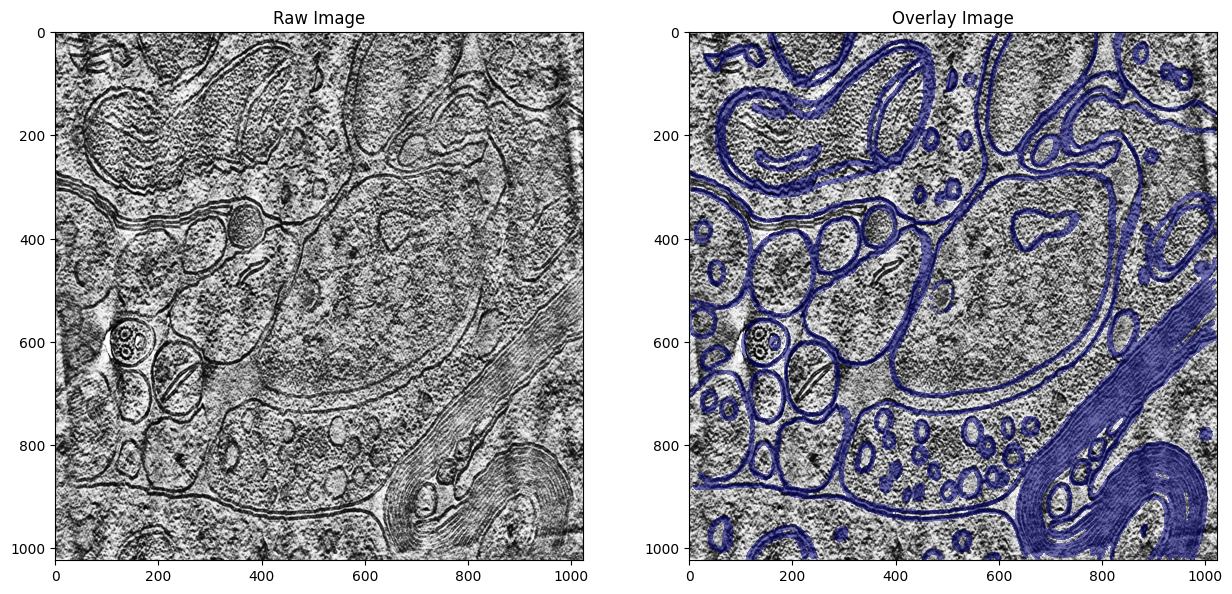

In [6]:
raw_tomogram = r"1.1_folder\Pos_3_6_9_test_data_2/Pos_3_6_9_52Apx_rawEqualizedvolume.nii"
overlay_file = r"1.1_folder\Pos_3_6_9_test_data_2/Pos_3_6_9_52Apx_overlay_all_equalized.nii"
plot_overlayed_blobs(raw_file = raw_tomogram, overlay_file = overlay_file, z = 200)

In [7]:
plot_raw_and_overlay_play(raw_file = raw_tomogram, overlay_file = overlay_file)

interactive(children=(IntSlider(value=0, description='Slice', max=375), Output()), _dom_classes=('widget-inter…

TraitError: The 'disabled' trait of a Button instance expected a boolean, not the int 9.

TraitError: The 'disabled' trait of a Button instance expected a boolean, not the int 60.

TraitError: The 'disabled' trait of a Button instance expected a boolean, not the int 197.

### Create binary label mask for model training 

In [2]:
def create_mask_nii(overlay_file_path, output_folder_path, prefix):
    """
    Creates a mask volume from an overlay NIfTI file, setting the regions with labels to 255.

    Parameters:
    overlay_file_path (str): Path to the input NIfTI file containing the overlay data.
    output_folder_path (str): Directory where the new mask NIfTI file will be saved.

    Returns:
    str: Path to the saved mask NIfTI file.

    Process:
    1. Load the overlay NIfTI file.
    2. Create an empty mask array initialized to zeros.
    3. Set regions in the mask where the overlay data equals 1 to 255.
    4. Create a new NIfTI file using the mask and the affine transformation from the overlay file.
    5. Check if the output folder exists and create it if it does not.
    6. Save the new mask NIfTI file in the specified folder.
    7. Return the path to the saved mask NIfTI file.
    """

    # Load overlay.nii file
    overlay = nib.load(overlay_file_path)

    # Create an empty mask initialized with zeros
    mask = np.zeros(overlay.shape, dtype=np.uint8)

    # Set the label regions in the mask
    mask[overlay.get_fdata() == 1] = 255

    # Create a new NIfTI file for the label
    label_nii = nib.Nifti1Image(mask, affine=overlay.affine)

    # Save the new NIfTI file in the specified folder
    output_file_path = os.path.join(output_folder_path, f'{prefix}_label255_equalized.nii')
    nib.save(label_nii, output_file_path)

    # Return the path to the output file
    return output_file_path



def create_binary_mask_nii(overlay_file_path, output_folder_path, prefix):
    """
    Creates a binary mask volume from an overlay NIfTI file, setting the regions with labels to 1.

    Parameters:
    overlay_file_path (str): Path to the input NIfTI file containing the overlay data.
    output_folder_path (str): Directory where the new binary mask NIfTI file will be saved.

    Returns:
    str: Path to the saved binary mask NIfTI file.

    Process:
    1. Load the overlay NIfTI file.
    2. Create an empty mask array initialized to zeros.
    3. Set regions in the mask where the overlay data equals 1 to 1.
    4. Create a new NIfTI file using the binary mask and the affine transformation from the overlay file.
    5. Check if the output folder exists and create it if it does not.
    6. Save the new binary mask NIfTI file in the specified folder.
    7. Return the path to the saved binary mask NIfTI file.
    """

    # Load overlay.nii file
    overlay = nib.load(overlay_file_path)

    # Create an empty mask initialized with zeros
    mask = np.zeros(overlay.shape, dtype=np.uint8)

    # Set the label regions in the mask
    mask[overlay.get_fdata() == 1] = 1

    # Create a new NIfTI file for the label
    label_nii = nib.Nifti1Image(mask, affine=overlay.affine)

    # Check if the output folder exists, and create it if it doesn't
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)

    # Save the new NIfTI file in the specified folder
    output_file_path = os.path.join(output_folder_path, f'{prefix}_binary_label_equalized.nii')
    nib.save(label_nii, output_file_path)

    # Return the path to the output file
    return output_file_path

In [19]:
overlay_file = r"1.1_folder\Pos_3_6_9_test_data_2/Pos_3_6_9_52Apx_overlay_all_equalized.nii"
output_prefix = "Pos_3_6_9"

In [20]:
output_file_path = create_mask_nii(overlay_file_path = overlay_file, output_folder_path = r"1.1_folder/Pos_3_6_9_test_data_2", prefix = output_prefix)
print(output_file_path)

1.1_folder/Pos_3_6_9_test_data_2\Pos_3_6_9_label255_equalized.nii


In [21]:
output_file_path = create_binary_mask_nii(overlay_file_path = overlay_file, output_folder_path = r"1.1_folder/Pos_3_6_9_test_data_2", prefix = output_prefix)
print(output_file_path)

1.1_folder/Pos_3_6_9_test_data_2\Pos_3_6_9_binary_label_equalized.nii


In [2]:
def remove_singleton_dimension_binary_mask(binary_mask_dir):
    """
    Loads a binary mask in NiFti format, removes singleton dimensions.

    Parameters:
        - binary_mask_dir (str): directory (with filename) for the bianary mask NiFti file.    
    """

    # Load the binary mask NiFti file
    binary_mask_img = nib.load(binary_mask_dir)
    binary_mask_data = binary_mask_img.get_fdata()
    affine = binary_mask_img.affine

    # Remove singleton dimensions
    print(f"Original dimensions: {binary_mask_data.shape}")
    binary_mask_data = np.squeeze(binary_mask_data)
    print(f"New dimensions: {binary_mask_data.shape}")

    # Save binary mask without singleton dimension as the same name
    binary_label_nii = nib.Nifti1Image(binary_mask_data, affine)
    nib.save(binary_label_nii, binary_mask_dir)

    return binary_mask_data


def print_binary_mask_info(binary_mask_dir):
    """
    Loads a binary mask NIfTI file, removes any singleton dimensions, prints the shape,
    unique values, and their counts, and returns the binary mask data.

    Parameters:
    binary_mask_dir (str): Path to the binary mask NIfTI file.

    Returns:
    np.ndarray: The binary mask data with singleton dimensions removed.
    """
    # Load the binary mask NIfTI file
    binary_mask_img = nib.load(binary_mask_dir)
    binary_mask_data = binary_mask_img.get_fdata()

    # Remove singleton dimensions
    #binary_mask_data = np.squeeze(binary_mask_data)

    # Print the shape of the binary mask data
    print("Shape of binary mask:", binary_mask_data.shape)

    # Get unique values and their counts
    unique_values, counts = np.unique(binary_mask_data, return_counts=True)

    # Print unique values and their counts
    print("\nUnique values and their counts:")
    for value, count in zip(unique_values, counts):
        print(f"Value: {value}, Count: {count}")
        print(f"Type of binary mask values: {type(value)}\n")

    return binary_mask_data
    

In [23]:
binary_mask_dir = r"1.1_folder/Pos_3_6_9_test_data_2/Pos_3_6_9_binary_label_equalized.nii"
binary_mask_data = remove_singleton_dimension_binary_mask(binary_mask_dir = binary_mask_dir)

Original dimensions: (1024, 1024, 376, 1)
New dimensions: (1024, 1024, 376)


In [3]:
binary_mask_dir = r"1.1_folder/Pos_3_6_9_test_data_2/Pos_3_6_9_binary_label_equalized.nii"
binary_mask_data = print_binary_mask_info(binary_mask_dir = binary_mask_dir)

Shape of binary mask: (1024, 1024, 376)


### TITLE

In [3]:
#plot the raw and mask side by side (works only in jupyter notebook)
def plot_raw_and_label(raw_file, label_file):
    raw_img = nib.load(raw_file)
    raw_data = raw_img.get_fdata()
    #raw_data = np.flip(raw_data, axis=1)
    
    label_img = nib.load(label_file)
    label_data = label_img.get_fdata()
    label_data = np.flip(label_data, axis=1)
    
    def update(z):
        fig, ax = plt.subplots(1, 2, figsize=(15, 15))
        ax[0].imshow(raw_data[:, :, z], cmap='gray')
        ax[0].set_title('Raw Image')
        ax[1].imshow(label_data[:, :, z], cmap="gray", vmin=0, vmax=1)
        ax[1].set_title('Label Image')
        plt.show()        
    play = widgets.Play(interval=500, value=0, min=0, max=raw_data.shape[2]-1, step=1, description="Play")
    z_slider = widgets.IntSlider(min=0, max=raw_data.shape[2]-1, step=1, value=0, description="Slice")
    widgets.jslink((play, 'value'), (z_slider, 'value'))
    button_layout = widgets.Layout(width='80px')
    play_button = widgets.Button(description=">", layout=button_layout)
    widgets.jslink((play, 'value'), (play_button, 'disabled'))

    def on_play_button_click(b):
        if play.value==play.max:
            play.value=play.min
            play_button.description=">"
        elif play.playing:
            play.stop()
            play_button.description = "Play"
        else:
            play.play()
            play_button.description = "Pause"

    play_button.on_click(on_play_button_click)
    display(widgets.HBox([z_slider, play, play_button]))

    interact(update, z=z_slider)

In [4]:
raw_file = r"1.1_folder/Pos_3_6_9_test_data_2/Pos_3_6_9_52Apx_rawEqualizedvolume.nii"
label_file = r"1.1_folder/Pos_3_6_9_test_data_2/Pos_3_6_9_binary_label_equalized.nii"

plot_raw_and_label(raw_file = raw_file, label_file = label_file)

interactive(children=(IntSlider(value=0, description='Slice', max=375), Output()), _dom_classes=('widget-inter…

TraitError: The 'disabled' trait of a Button instance expected a boolean, not the int 3.

TraitError: The 'disabled' trait of a Button instance expected a boolean, not the int 212.

TraitError: The 'disabled' trait of a Button instance expected a boolean, not the int 266.

TraitError: The 'disabled' trait of a Button instance expected a boolean, not the int 263.

TraitError: The 'disabled' trait of a Button instance expected a boolean, not the int 254.

TraitError: The 'disabled' trait of a Button instance expected a boolean, not the int 136.

TraitError: The 'disabled' trait of a Button instance expected a boolean, not the int 139.

TraitError: The 'disabled' trait of a Button instance expected a boolean, not the int 148.

TraitError: The 'disabled' trait of a Button instance expected a boolean, not the int 203.